In [45]:
import pickle
import gzip
from ising_utils import *
import numpy as np
import pandas as pd
from ipywidgets import interact, IntSlider
from scipy.stats import gaussian_kde

In [5]:
def bornholdt_field(model, i):
    """Compute the local field at spin i"""
    total_neighbors = np.sum(model.connection_matrix[i] * model.spins)
    magnetization = np.sum(model.spins) / len(model.spins)
    return model.params['J'] * total_neighbors - model.params['alpha'] * model.strategy_list[-1]['C'][i] * magnetization

In [6]:
def bornholdt_update_strategy(model):
    current_C = model.strategy_list[-1]['C']
    next_C = np.copy(current_C)
    alpha_mag = model.params['alpha']*np.sum(model.spins)
    for i in range(model.size):
        if model.spins[i]*current_C[i]*alpha_mag < 0:
            next_C[i] = -current_C[i]
    return {'C': next_C}

In [7]:
def bornholdt_constant_strategy(model):
    return {'C': model.strategy_list[-1]['C']}

In [8]:
with open('bornholdt_model_long_sim_J1.0_alpha4.0_T1.5_C502.pkl', 'rb') as f:
    model = pickle.load(f)

In [16]:
magnetization_series = np.array([np.sum(spins) for spins in model.spin_series])

In [51]:
def calculate_transition_probabilities(magnetization_series, n_step=1):
    """
    Calculate empirical transition probabilities P(m_{t+n}|m_t) from magnetization time series.
    
    Parameters:
    -----------
    magnetization_series : array-like
        Time series of magnetization values
    n_step : int
        Number of time steps for transition (default=1)
        
    Returns:
    --------
    pd.DataFrame
        Transition probability matrix where:
        - index represents m_t (initial magnetization)
        - columns represent m_{t+n} (final magnetization)
        - values are P(m_{t+n}|m_t)
    """
    # Create pairs of (m_t, m_{t+n})
    m_t = magnetization_series[:-n_step]
    m_t_plus_n = magnetization_series[n_step:]
    
    # Create DataFrame of transitions
    transitions = pd.DataFrame({
        'm_t': m_t,
        'm_t_plus_n': m_t_plus_n
    })
    
    # Calculate conditional probabilities
    transition_matrix = pd.crosstab(
        transitions['m_t'], 
        transitions['m_t_plus_n'], 
        normalize='index'
    )
    
    return transition_matrix

In [ ]:
def calculate_transition_probabilities(magnetization_series, n_step=1):
    """
    Calculate empirical transition probabilities P(m_{t+n}|m_t) from magnetization time series.
    
    Parameters:
    -----------
    magnetization_series : array-like
        Time series of magnetization values
    n_step : int
        Number of time steps for transition (default=1)
        
    Returns:
    --------
    pd.DataFrame
        Transition probability matrix where:
        - index represents m_t (initial magnetization)
        - columns represent m_{t+n} (final magnetization)
        - values are P(m_{t+n}|m_t)
    """
    # Create pairs of (m_t, m_{t+n})
    m_t = magnetization_series[:-n_step]
    m_t_plus_n = magnetization_series[n_step:]
    
    # Create DataFrame of transitions
    transitions = pd.DataFrame({
        'm_t': m_t,
        'm_t_plus_n': m_t_plus_n
    })
    
    # Calculate conditional probabilities
    transition_matrix = pd.crosstab(
        transitions['m_t'], 
        transitions['m_t_plus_n'], 
        normalize='index'
    )
    
    return transition_matrix

In [61]:
def calculate_transition_probabilities(magnetization_series, n_step=1, n_bins=50):
    """
    Calculate binned transition probabilities P(m_{t+n}|m_t) from magnetization time series.
    
    Parameters:
    -----------
    magnetization_series : array-like
        Time series of magnetization values
    n_step : int
        Number of time steps for transition
    n_bins : int
        Number of bins for discretizing magnetization values
    """
    # Create bins
    bins = np.linspace(
        min(magnetization_series), 
        max(magnetization_series), 
        n_bins
    )
    
    # Bin the data
    m_t = pd.cut(magnetization_series[:-n_step], bins=bins)
    m_t_plus_n = pd.cut(magnetization_series[n_step:], bins=bins)
    
    # Calculate transitions
    transitions = pd.DataFrame({
        'm_t': m_t,
        'm_t_plus_n': m_t_plus_n
    })
    
    # Get probability matrix
    trans_matrix = pd.crosstab(
        transitions['m_t'], 
        transitions['m_t_plus_n'], 
        normalize='index'
    )
    
    # # Optionally smooth the distribution
    # from scipy.ndimage import gaussian_filter
    # smoothed_matrix = gaussian_filter(trans_matrix.values, sigma=1)
    
    return pd.DataFrame(
        trans_matrix, 
        index=trans_matrix.index, 
        columns=trans_matrix.columns
    )

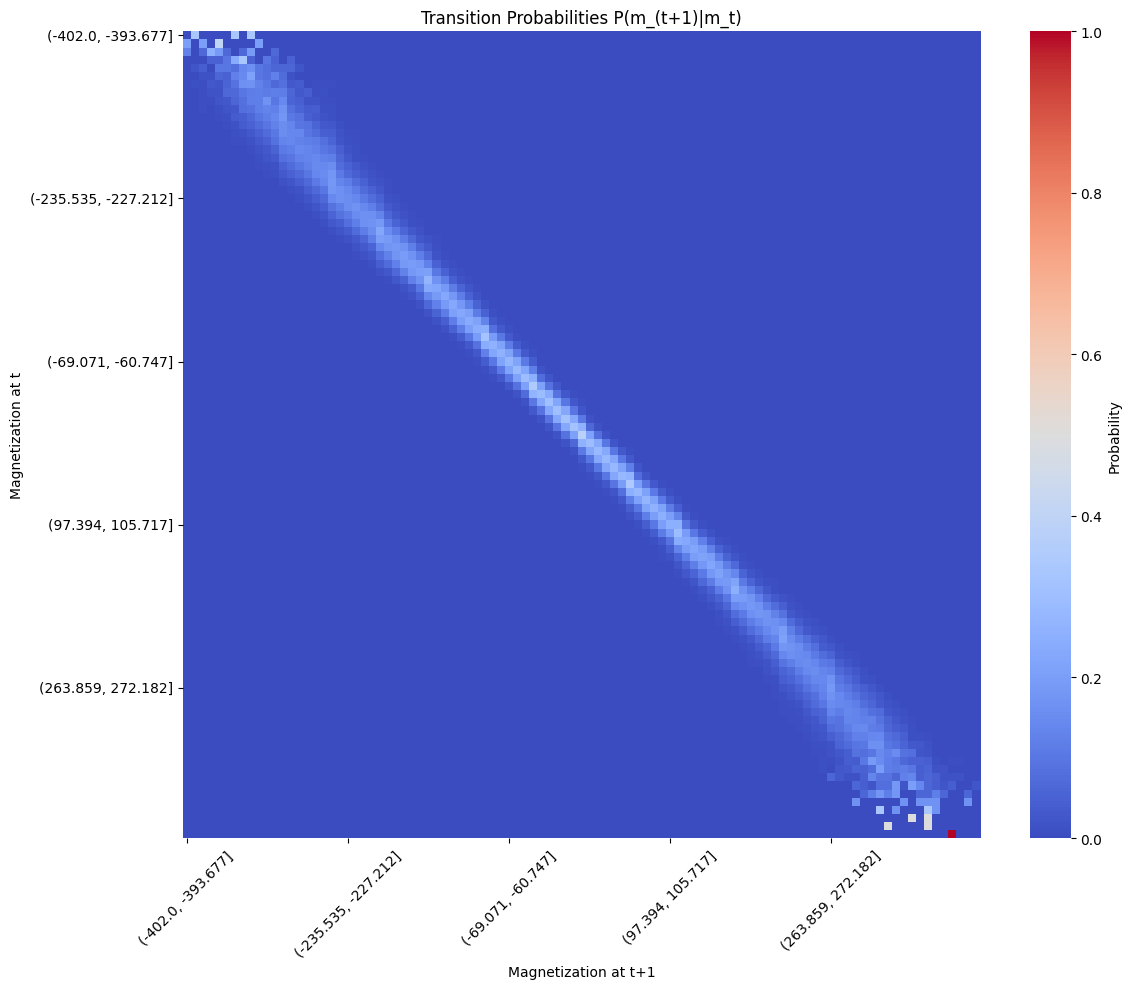

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_transition_matrix(magnetization_series, n_step=1, n_bins=50, cmap='viridis'):
    # Calculate transition probabilities
    trans_matrix = calculate_transition_probabilities(magnetization_series, n_step=n_step, n_bins=n_bins)
    
    # Create figure
    plt.figure(figsize=(12, 10))
    
    # Create heatmap
    sns.heatmap(trans_matrix, 
                cmap=cmap,
                xticklabels=20,  # Show fewer ticks for clarity
                yticklabels=20,
                cbar_kws={'label': 'Probability'})
    
    plt.title(f'Transition Probabilities P(m_(t+{n_step})|m_t)')
    plt.xlabel('Magnetization at t+{}'.format(n_step))
    plt.ylabel('Magnetization at t')
    
    # Rotate tick labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()

# Example usage
plot_transition_matrix(magnetization_series, n_step=1, n_bins=100, cmap='coolwarm')

In [62]:
calculate_transition_probabilities(magnetization_series, n_step=1)

m_t_plus_n,"(-402.0, -385.184]","(-385.184, -368.367]","(-368.367, -351.551]","(-351.551, -334.735]","(-334.735, -317.918]","(-317.918, -301.102]","(-301.102, -284.286]","(-284.286, -267.469]","(-267.469, -250.653]","(-250.653, -233.837]",...,"(253.837, 270.653]","(270.653, 287.469]","(287.469, 304.286]","(304.286, 321.102]","(321.102, 337.918]","(337.918, 354.735]","(354.735, 371.551]","(371.551, 388.367]","(388.367, 405.184]","(405.184, 422.0]"
m_t,,,,,,,,,,,,,,,,,,,,,
"(-402.0, -385.184]",0.250000,0.125000,0.250000,0.125000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"(-385.184, -368.367]",0.054054,0.162162,0.216216,0.324324,0.135135,0.081081,0.027027,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"(-368.367, -351.551]",0.006211,0.037267,0.142857,0.223602,0.291925,0.204969,0.080745,0.012422,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"(-351.551, -334.735]",0.004357,0.023965,0.093682,0.187364,0.263617,0.222222,0.126362,0.061002,0.013072,0.004357,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"(-334.735, -317.918]",0.000804,0.008039,0.043408,0.108521,0.246785,0.266881,0.194534,0.094051,0.032154,0.004823,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"(-317.918, -301.102]",0.000000,0.000452,0.011292,0.051039,0.156730,0.226739,0.259259,0.200542,0.066396,0.023035,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"(-301.102, -284.286]",0.000000,0.000541,0.001892,0.014058,0.071100,0.169505,0.251960,0.266288,0.144904,0.066775,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"(-284.286, -267.469]",0.000000,0.000000,0.000166,0.003149,0.020222,0.071606,0.178021,0.298359,0.240676,0.145699,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"(-267.469, -250.653]",0.000000,0.000000,0.000000,0.000421,0.003653,0.021073,0.083310,0.215650,0.292076,0.249789,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [52]:
current_price = 0

def plot_price_distribution(starting_price, time_to_expiration):
    plt.figure(figsize=(10, 5))
    plt.plot(calculate_transition_probabilities(magnetization_series, n_step=time_to_expiration).loc[starting_price])
    plt.xlabel(f'price at t+{time_to_expiration}')
    plt.ylabel(f'probability of price at t')
    plt.title(f'Price transition probabilities for {starting_price} at t')

interact(lambda x: plot_price_distribution(current_price, x),
         x=IntSlider(min=1, max=50, step=1, value=time_to_expiration, continuous_update=False))

interactive(children=(IntSlider(value=20, continuous_update=False, description='x', max=50, min=1), Output()),…

<function __main__.<lambda>(x)>